# Extract Trajectory from Video

In [36]:
from pathlib import Path
import os
from pytube import YouTube
import cv2
import pandas as pd
import numpy as np
import matplotlib.pylab as plt


%run ../lib.py

/Users/eric/proj/PINNiped/video


In [38]:
# Download the videos, if necessary

vid_urls = [
    ('https://youtu.be/mzZrpmhBnkQ?feature=shared',  'basketball.mp4'),
    ('https://youtu.be/Iv3upkhSJ9U?feature=shared&t=9','canon.mp4'),
    ('', 'ball_trajectory.mp4') # video is generated
]

vids = []

for url, vfn in vid_urls:
    vf = vd/vfn
    if not vf.exists():
        yt = YouTube(url).streams.first()
        print("Download",  vfn)
        fp = yt.download(output_path=vd, filename=vfn)

    vids.append(vf)


In [ ]:
def extract_traj(fp, centroid_func=None, ex_frame=.5):
    """Run extraction function and generate dataframe, for each frame in the movie"""
    # Open the video file
    cap = cv2.VideoCapture(fp)

    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Iterate over the frames
    frame_count = 0
    rows = []
    frame_shown = False
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        if centroid_func:
            centroid, aframe = centroid_func(frame)
            rows.append({
                'x': centroid[0],
                'y': centroid[1]
            })
        else:
            aframe = frame
    
        if not frame_shown and frame_count > n_frames*ex_frame:
            
            frame_rgb = cv2.cvtColor(aframe, cv2.COLOR_BGR2RGB)
            
            # Display the frame using matplotlib
            plt.imshow(frame_rgb)
            plt.axis('off')  # Turn off axis numbers and ticks
            plt.show()

            frame_shown = True
        
    cap.release()

    if rows:
        df = pd.DataFrame(rows)
        
        #t['x'] = t.x.max() - t.x
        df['y'] = df.y.max() - df.y
    
        return df

In [ ]:
def find_cannonball_centroid_color(image):
    """Find the centroid for the canon ball in the canon video. """
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define color range for the red cannonball
    # FIXME?> I think this should acrtually be a split range for red in  HSV
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([8, 255, 255])

    # Create a mask for the red color
    mask = cv2.inRange(hsv, lower_red, upper_red)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If no contours found, handle the case
    if len(contours) == 0:
        return None, image

    # Assume the largest contour is the cannonball
    cannonball_contour = max(contours, key=cv2.contourArea)

    # Compute the centroid of the cannonball
    M = cv2.moments(cannonball_contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0

    # Draw the contour and centroid on the image
    cv2.drawContours(image, [cannonball_contour], -1, (0, 255, 0), 2)
    cv2.circle(image, (cX, cY), 2, (255, 0, 0), -1)
   
    return (cX, cY), image

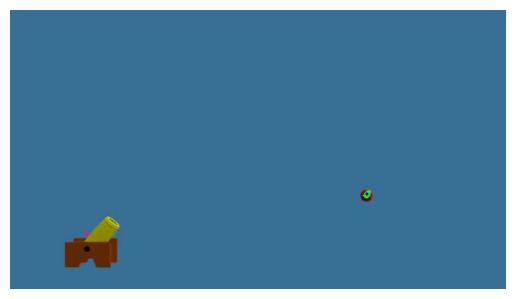

<Axes: xlabel='x'>

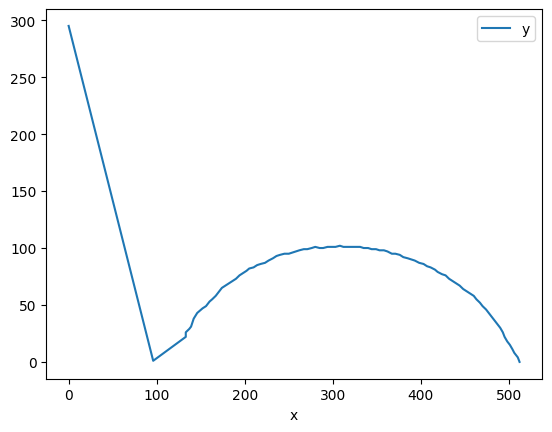

In [ ]:
df = extract_traj(vids[1], find_cannonball_centroid_color, ex_frame=.5)

df.plot(x='x', y='y')

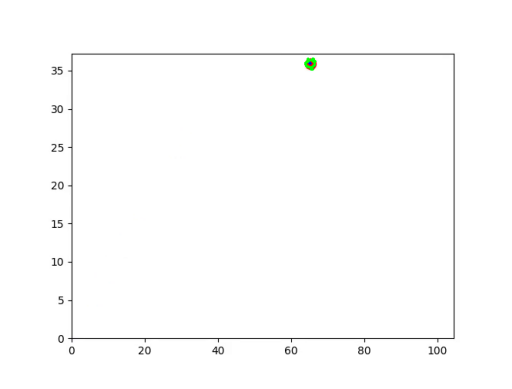

<Axes: xlabel='x'>

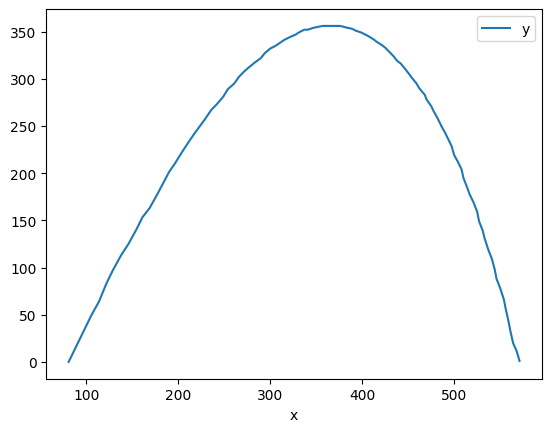

In [42]:


df = extract_traj(vids[2], find_cannonball_centroid_color, ex_frame=.5)

df.plot(x='x', y='y')

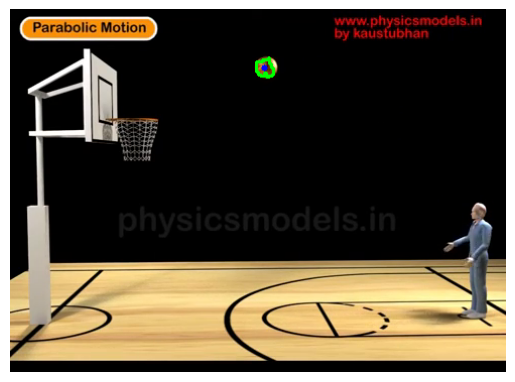

<Axes: xlabel='x'>

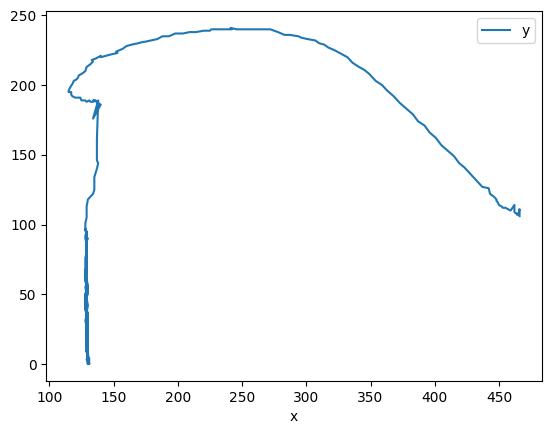

In [21]:
def find_basketball_centroid(image):
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define color range for the basketball (shades of orange)
    lower_orange = np.array([5, 100, 100])
    upper_orange = np.array([15, 255, 255])

    # Create a mask for the orange color
    mask = cv2.inRange(hsv, lower_orange, upper_orange)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If no contours found, handle the case
    if len(contours) == 0:
        return None, image

    # Assume the largest contour is the basketball
    basketball_contour = max(contours, key=cv2.contourArea)

    # Compute the centroid of the basketball
    M = cv2.moments(basketball_contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0

    # Draw the contour and centroid on the image
    cv2.drawContours(image, [basketball_contour], -1, (0, 255, 0), 2)
    cv2.circle(image, (cX, cY), 3, (255, 0, 0), -1)

    return (cX, cY), image
    
df = extract_traj(vids[0], find_basketball_centroid, ex_frame=.2)


In [ ]:
15//2